출처: https://dacon.io/codeshare/3725?dtype=recent

In [205]:
import os
import glob
import json
from glob import glob
from tqdm import tqdm
import time
import datetime
import math

import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO

import torch
import torch.optim as optim
from torch  import nn, Tensor

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from collections import defaultdict, deque

import base64
import torch.distributed as dist
from torch.utils.data import Dataset

In [206]:
!ls

coco_eval.py   drive	  __pycache__  transforms.py  vision
coco_utils.py  engine.py  sample_data  utils.py


## 버전 확인

In [207]:
print('torch :', torch.__version__)
print('torchvision : ', torchvision.__version__)
print('cv2 :', cv2.__version__)

torch : 1.10.0+cu111
torchvision :  0.11.1+cu111
cv2 : 4.1.2


## 전체 데이터 json 만들기

In [208]:
# # # 이건 저의 개인적인 코랩이기 때문에 다르신 분들은 다시 변경하시기 바랍니다.
# # ## train_PATH와 test_PATH만 변경하면 됩니다.
# # # json 파일로 만들어서 분석이 더 용이하다고 생각되어 만든 것이니 더 좋은 의견 있으면 말씀해주시기 바랍니다.

# ## Train
# train_PATH = '/content/drive/MyDrive/NIA 폐플라스틱 객체 검출 예측/Data/train/annotation'
# file_list = os.listdir(train_PATH)

# train_files = []
# for file in tqdm(file_list):
#     dir = train_PATH + '/' + file
#     json_list = glob(dir + '/' +'*.json')
#     train_files.append(json_list)

# train_json_list = []
# for files in tqdm(train_files):
#     for json_file in tqdm(files):
#         train_json_list.append(json_file)

# ## Test
# test_PATH = '/content/drive/MyDrive/NIA 폐플라스틱 객체 검출 예측/Data/test/annotations'
# file_list = os.listdir(test_PATH)

# test_files = []
# for file in tqdm(file_list):
#     dir = test_PATH + '/' + file
#     json_list = glob(dir + '/' + '*.json')
#     test_files.append(json_list)

# test_json_list = []
# for files in tqdm(test_files):
#     for json_file in tqdm(files):
#         test_json_list.append(json_file)

## Sample data에서 json 만들기

In [209]:
## Train
train_PATH = '/content/drive/MyDrive/NIA 폐플라스틱 객체 검출 예측/Sample_data/train/annotation'
file_list = os.listdir(train_PATH)

train_files = []
for file in tqdm(file_list):
    dir = train_PATH + '/' + file
    json_list = glob(dir + '/' +'*.json')
    train_files.append(json_list)

train_json_list = []
for files in tqdm(train_files):
    for json_file in tqdm(files):
        train_json_list.append(json_file)


test_PATH = '/content/drive/MyDrive/NIA 폐플라스틱 객체 검출 예측/Sample_data/test/annotations'
file_list = os.listdir(test_PATH)
test_files = []
for file in tqdm(file_list):
    dir = test_PATH + '/' + file
    json_list = glob(dir + '/' +'*.json')
    test_files.append(json_list)

test_json_list = []
for files in tqdm(test_files):
    for json_file in tqdm(files):
        test_json_list.append(json_file)

100%|██████████| 56/56 [00:00<00:00, 466033.78it/s]

100%|██████████| 56/56 [00:00<00:00, 536258.05it/s]

100%|██████████| 56/56 [00:00<00:00, 568719.19it/s]

100%|██████████| 14/14 [00:00<00:00, 152125.02it/s]

100%|██████████| 14/14 [00:00<00:00, 186413.51it/s]

100%|██████████| 14/14 [00:00<00:00, 84126.44it/s]

100%|██████████| 4/4 [00:00<00:00, 170.51it/s]


In [210]:
import os
import numpy as np
import torch
from PIL import Image

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms = None, mode = 'train', json_file = None):
        self.mode = mode
        self.root = root
        self.transforms = transforms
        self.json_file = json_file

    def __getitem__(self, idx):
        if self.mode == 'train':

            annot = json_file[idx]
            # Train의 경로로 이동한다.
            # 나중에 진짜 데이터를 다룰 때 사용한다.
            # PATH = root + '/' + 'train'

            with open(annot, 'r') as f:
                annot = json.loads(f.read())
                
            image_name = annot['images'][0]['file_name']
            dir = image_name.split('_')[0]

            image_PATH = self.root + '/' + 'train' + '/' +'image' +'/' + dir + '/' + image_name
            
            img = Image.open(image_PATH).convert('RGB')

            boxes = []
            segmentations = []
            labels = []

            for i in range(len(annot['annotations'])):

                segmentation = annot['annotations'][i]['segmentation'][0]
                bbox = annot['annotations'][i]['bbox']
                label = torch.tensor(annot['annotations'][i]['category_id'], dtype = np.uint8)
                xmin, ymin, width, height = bbox[0],bbox[1],bbox[2],bbox[3]
                xmin, ymin, xmax, ymax = xmin, ymin, xmin + width, ymax + height
                
                boxes.append(torch.as_tensor([xmin, ymin, xmax, ymax], dtype = torch.float32))
                segmentations.append([segmentation])
                labels.append(label)

            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            target['segmentation'] = segmentations
            target['image_id'] = torch.tensor(idx)

            if self.transforms is not None:
                img, target = self.transforms(img, target)

            return img, target

        if self.mode == 'test':
            # Test의 경로로 이동한다.
            # PATH = root + '/' + 'test'
            # 나중에 진짜 데이터를 다룰 때 사용한다.
            annot = json_file[idx]

            ##### 이 부분은 추후에 작성하기로 하자.
            with open(annot, 'r') as f:
                annot = json.loads(f.read())

            image_name = annot['images'][0]['file_name']
            dir = image_name[:2]

            image_PATH = PATH + '/' + dir + '/' + image_name
            image = Image.open(image_PATH).convert('RGB')
            target = {}

            target['image_id'] = image_name

            return image, target

    def __len__(self):
        return len(self.json_file)

In [211]:
root = '/content/drive/MyDrive/NIA 폐플라스틱 객체 검출 예측/Sample_data'
train_dataset = CustomDataset(root = root,json_file = train_json_list, mode = 'train')
test_dataset = CustomDataset(root = root, json_file = test_json_list, mode = 'test')

## Pytorch Tutorial을 가지고 분석을 진행해 보기

https://tutorials.pytorch.kr/intermediate/torchvision_tutorial.html

PET를 먼저 진행해 보고 추후에 나머지도 진행해 볼 예정입니다.

In [212]:
with open('/content/drive/MyDrive/NIA 폐플라스틱 객체 검출 예측/Sample_data/train/annotation/PP/PP_050_1520.json', 'r') as f:
    data = json.loads(f.read())

print(data['images'][0]['file_name'].split('_')[1])

050


In [213]:
import torch
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.categories = {1 : 'pet', 2 : 'ps', 3 : 'pp', 4 : 'pe'}

        mode = self.root.split('/')[-1]
        self.mode = mode

        self.imgs = list(sorted(os.listdir(os.path.join(root, 'image', 'PET'))))
        if self.mode == 'train':
            self.annot = list(sorted(os.listdir(os.path.join(root, 'annotation', 'PET'))))
        else:
            self.annot = list(sorted(os.listdir(os.path.join(root, 'annotations', 'PET'))))

    def __getitem__(self, idx):
        if self.mode == 'train':
            img_path = os.path.join(self.root, 'image','PET', self.imgs[idx])

            annot_path = os.path.join(self.root, 'annotation','PET',self.annot[idx])

            with open(annot_path, 'r') as f:
                annot = json.loads(f.read())
            
            # 이 부분은 그냥 숫자를 idx를 넣는 부분과 숫자를 넣는 부분이 있고 저는 아무것도 안할 것 이기 때문에 데이터에 그냥 뽑아온 값입니다~
            image_id = int(annot_path.split('/')[-1].split('_')[1])

            img = Image.open(img_path).convert('RGB')

            # width, height로 0인 이미지 생성하여 segmentation 넣어주기
            x = annot['images'][0]['width']
            y = annot['images'][0]['height']

            #각 마스크를 target으로 사용해야함
            annot = annot['annotations']

            # area, iscrowd는 채울 방법이 없어서 그냥 bbox를 채워넣기로 하자.
            mask = []
            boxes = []
            labels = []
            iscrowd = []
            area = []
            masked_image = np.zeros((x, y), dtype = np.uint8)

            for i in range(len(annot)):
                segmentation = annot[i]['segmentation'][0]
                areas = annot[i]['area']
                iscrowds = annot[i]['iscrowd']
                xmin, ymin, width, height = annot[i]['bbox'][0], annot[i]['bbox'][1], annot[i]['bbox'][2], annot[i]['bbox'][3]
                xmax = xmin + width
                ymax = ymin + height

                label = annot[i]['category_id']

                all_points_x = []
                all_points_y = []

                for j in range(len(segmentation)):
                    if j%2 == 0:
                        all_points_x.append(segmentation[j])
                    else:
                        all_points_y.append(segmentation[j])

                polygon_xy = np.array([(x,y) for (x,y) in zip(all_points_x, all_points_y)])

                cv2.fillPoly(masked_image, np.uint([polygon_xy]), i+1)

                # mask.append(masked_image)
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(label)
                area.append(areas)
                iscrowd.append(iscrowds)

            mask = np.array(masked_image)
            obj_ids = np.unique(mask)
            obj_ids = obj_ids[1:]
            masks = mask == obj_ids[:, None, None]
            num_objs = len(obj_ids)
            

            boxes = torch.as_tensor(boxes, dtype = torch.float32)
            labels = torch.ones((num_objs,), dtype = torch.int64)
            mask = torch.as_tensor(masks, dtype = torch.uint8)
            image_id = torch.tensor([image_id])
            area = torch.as_tensor(area, dtype = torch.float32)
            iscrowd = torch.as_tensor(iscrowd, dtype = torch.int32)

            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            target['masks'] = mask
            target['image_id'] = image_id
            target['area'] = area
            target['iscrowd'] = iscrowd

            img = self.preprocess(img)

            return img, target
            
        if self.mode == 'test':
            img_path = os.path.join(self.root, 'image','PET', self.imgs[idx])

            annot_path = os.path.join(self.root, 'annotations','PET',self.annot[idx])

            with open(annot_path, 'r') as f:
                annot = json.loads(f.read())
            
            # 이 부분은 그냥 숫자를 idx를 넣는 부분과 숫자를 넣는 부분이 있고 저는 아무것도 안할 것 이기 때문에 데이터에 그냥 뽑아온 값입니다~
            image_id = int(annot_path.split('/')[-1].split('_')[1])

            img = Image.open(img_path).convert('RGB')

            # width, height로 0인 이미지 생성하여 segmentation 넣어주기
            x = annot['images'][0]['width']
            y = annot['images'][0]['height']

            #각 마스크를 target으로 사용해야함
            annot = annot['annotations']

            # area, iscrowd는 채울 방법이 없어서 그냥 bbox를 채워넣기로 하자.
            mask = []
            boxes = []
            labels = []
            iscrowd = []
            area = []
            masked_image = np.zeros((x, y), dtype = np.uint8)

            for i in range(len(annot)):
                segmentation = annot[i]['segmentation'][0]
                areas = annot[i]['area']
                iscrowds = annot[i]['iscrowd']
                xmin, ymin, width, height = annot[i]['bbox'][0], annot[i]['bbox'][1], annot[i]['bbox'][2], annot[i]['bbox'][3]
                xmax = xmin + width
                ymax = ymin + height

                label = annot[i]['category_id']

                all_points_x = []
                all_points_y = []

                for j in range(len(segmentation)):
                    if j%2 == 0:
                        all_points_x.append(segmentation[j])
                    else:
                        all_points_y.append(segmentation[j])

                polygon_xy = np.array([(x,y) for (x,y) in zip(all_points_x, all_points_y)])

                cv2.fillPoly(masked_image, np.uint([polygon_xy]), i+1)

                # mask.append(masked_image)
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(label)
                area.append(areas)
                iscrowd.append(iscrowds)

            # masked_image = np.zeros((x,y), dtype = np.uint8)


            mask = np.array(masked_image)
            obj_ids = np.unique(mask)
            obj_ids = obj_ids[1:]
            masks = mask == obj_ids[:, None, None]
            num_objs = len(obj_ids)
            

            boxes = torch.as_tensor(boxes, dtype = torch.float32)
            labels = torch.ones((num_objs,), dtype = torch.int64)
            mask = torch.as_tensor(masks, dtype = torch.uint8)
            image_id = torch.tensor([image_id])
            area = torch.as_tensor(area, dtype = torch.float32)
            iscrowd = torch.as_tensor(iscrowd, dtype = torch.int32)

            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            target['masks'] = mask
            target['image_id'] = image_id
            target['area'] = area
            target['iscrowd'] = iscrowd

            img = self.preprocess(img)

            return img, target



    def preprocess(self, img):
        image = img
        import torchvision.transforms as T
        m, s = np.mean(image, axis = (0, 1)), np.std(image, axis = (0, 1))        
        if self.mode == 'train':
            transform = T.Compose([
                                   T.ToTensor(),
                                   T.Normalize(mean = m, std = s),
            ])
            image = transform(image)
        else:
            transform = T.Compose([
                                #    T.Resize(256),
                                   T.ToTensor(),
                                   T.Normalize(mean = m, std = s),
            ])
            image = transform(image)
        return image


    def __len__(self):
        return len(self.imgs)

In [214]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)

num_classes = 1 + 1 # 원래 클래스 + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [215]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# 분류 목적으로 미리 학습된 모델을 로드하고 특징들만을 리턴하도록 합니다
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# Faster RCNN은 백본의 출력 채널 수를 알아야 합니다.
# mobilenetV2의 경우 1280이므로 여기에 추가해야 합니다.
backbone.out_channels = 1280

# RPN(Region Proposal Network)이 5개의 서로 다른 크기와 3개의 다른 측면 비율(Aspect ratio)을 가진
# 5 x 3개의 앵커를 공간 위치마다 생성하도록 합니다.
# 각 특징 맵이 잠재적으로 다른 사이즈와 측면 비율을 가질 수 있기 때문에 Tuple[Tuple[int]] 타입을 가지도록 합니다.

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# 관심 영역의 자르기 및 재할당 후 자르기 크기를 수행하는 데 사용할 피쳐 맵을 정의합니다.
# 만약 백본이 텐서를 리턴할때, featmap_names 는 [0] 이 될 것이라고 예상합니다.
# 일반적으로 백본은 OrderedDict[Tensor] 타입을 리턴해야 합니다.
# 그리고 특징맵에서 사용할 featmap_names 값을 정할 수 있습니다.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# 조각들을 Faster RCNN 모델로 합칩니다.
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [216]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [217]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at 2f40a483 [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [218]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T
# from torchvision import transforms as T

def get_transform(train):
    transforms = []
    # transforms.append(T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)))
    transforms.append(T.ToTensor())
    # transforms.append(T.Resize(256))

    # transforms.append(T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
    if train:
        # (역자주: 학습시 50% 확률로 학습 영상을 좌우 반전 변환합니다)
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [219]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = CustomDataset('/content/drive/MyDrive/NIA 폐플라스틱 객체 검출 예측/Sample_data/train', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

In [220]:
# from keras.preprocessing.image import array_to_img
# from torchvision.transforms.functional import to_pil_image
# from torchvision import transforms

# data = to_pil_image(targets[0]['masks'])
# data.putpalette([
#     0, 0, 0, # black background
#     255, 0, 0, # index 1 is red
#     255, 255, 0, # index 2 is yellow
#     255, 153, 0, # index 3 is orange
# ])

# data
# # array_to_img

In [221]:
# use our dataset and defined transformations
dataset = CustomDataset('/content/drive/MyDrive/NIA 폐플라스틱 객체 검출 예측/Sample_data/train', get_transform(train=True))
dataset_test = CustomDataset('/content/drive/MyDrive/NIA 폐플라스틱 객체 검출 예측/Sample_data/test', get_transform(train=False))

# # split the dataset in train and test set
# torch.manual_seed(1)
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [222]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [223]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005
                            , weight_decay=0.005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3, gamma=0.1)

In [224]:
targets[0]['masks'].shape

torch.Size([3, 2024, 2024])

In [225]:
images[0].shape

torch.Size([3, 2024, 2024])

In [226]:
# 데이터는 제대로 들어가 있다.
print('train의 길이 :', len(data_loader.dataset))
print('test의 길이 :', len(data_loader_test.dataset))

train의 길이 : 56
test의 길이 : 14


In [227]:
# 이 친구는 왜 loss가 마이너스가 나와서 사람을 힘들게 하는지 알아봐야겠다~

# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 3

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)# let's train it for 10 epochs

Epoch: [0]  [ 0/28]  eta: 0:01:03  lr: 0.000019  loss: 4.4783 (4.4783)  loss_classifier: 0.5018 (0.5018)  loss_box_reg: 0.0093 (0.0093)  loss_mask: 3.4682 (3.4682)  loss_objectness: 0.4804 (0.4804)  loss_rpn_box_reg: 0.0186 (0.0186)  time: 2.2659  data: 2.0511  max mem: 5616
Epoch: [0]  [10/28]  eta: 0:00:08  lr: 0.000204  loss: 2.9856 (4.1827)  loss_classifier: 0.2807 (0.2761)  loss_box_reg: 0.0314 (0.0511)  loss_mask: 2.1774 (3.4042)  loss_objectness: 0.4088 (0.4200)  loss_rpn_box_reg: 0.0311 (0.0314)  time: 0.4931  data: 0.2949  max mem: 5616
Epoch: [0]  [20/28]  eta: 0:00:03  lr: 0.000389  loss: 1.7988 (2.8365)  loss_classifier: 0.2005 (0.2259)  loss_box_reg: 0.0682 (0.0676)  loss_mask: 1.3452 (2.2233)  loss_objectness: 0.1352 (0.2912)  loss_rpn_box_reg: 0.0283 (0.0285)  time: 0.3310  data: 0.1351  max mem: 5616
Epoch: [0]  [27/28]  eta: 0:00:00  lr: 0.000500  loss: 1.1683 (2.4004)  loss_classifier: 0.1786 (0.2141)  loss_box_reg: 0.0987 (0.0845)  loss_mask: 0.7352 (1.8374)  loss_ob

In [228]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [235]:
prediction[0]['scores']

tensor([0.1199, 0.1194, 0.1193, 0.1165, 0.1160, 0.1149, 0.1123, 0.1119, 0.1117,
        0.1117, 0.1107, 0.1100, 0.1092, 0.1033, 0.1022, 0.1022, 0.1017, 0.1012,
        0.1012, 0.1011, 0.1010, 0.1008, 0.1007, 0.1004, 0.1004, 0.1003, 0.1003,
        0.1002, 0.1002, 0.1001, 0.1001, 0.1001, 0.1000, 0.1000, 0.1000, 0.0998,
        0.0998, 0.0998, 0.0998, 0.0998, 0.0998, 0.0997, 0.0997, 0.0997, 0.0997,
        0.0997, 0.0997, 0.0997, 0.0996, 0.0996, 0.0996, 0.0996, 0.0996, 0.0995,
        0.0995, 0.0995, 0.0995, 0.0995, 0.0995, 0.0995, 0.0995, 0.0995, 0.0995,
        0.0994, 0.0994, 0.0994, 0.0993, 0.0993, 0.0993, 0.0993, 0.0993, 0.0993,
        0.0991, 0.0990, 0.0989, 0.0987, 0.0987, 0.0985, 0.0985, 0.0982, 0.0981,
        0.0980, 0.0980, 0.0980, 0.0976, 0.0975, 0.0973, 0.0971, 0.0970, 0.0970,
        0.0970, 0.0970, 0.0970, 0.0967, 0.0967, 0.0967, 0.0967, 0.0966, 0.0963,
        0.0960], device='cuda:0')

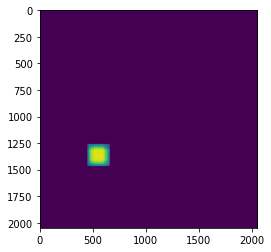

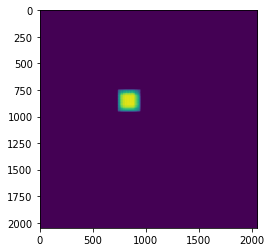

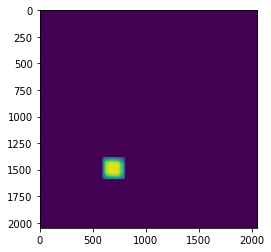

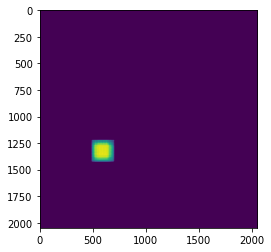

In [236]:
for i in range(len(prediction[0])):
    if prediction[0]['scores'][i] >= 0.113:
        plt.imshow(to_pil_image(prediction[0]['masks'][i]))
        plt.show()